# 목표

- CNN의 원리를 좀더 직관적으로 이해
- 실제 데이터의 변화 과정 확인
- 구현을 위해 특정 요소는 고정

In [18]:
import torch

# 이미지 준비 (1장)

In [19]:
import matplotlib.pyplot as plt
#pillow
from PIL import Image

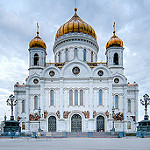

In [20]:
img = Image.open('/content/torch_cnn_sample.png')
img

In [21]:
import numpy as np

In [22]:
# 이미지를 배열로 변환
tmp = np.array( img )
tmp.shape, img.size
# 높이 150, 가로 150, 픽셀 1개를 표현하는 데이터랑 3체널 (칼라이미지)

((150, 150, 3), (150, 150))

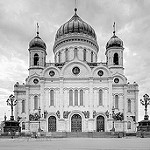

In [23]:
# 하위 작업을 원할하게 이해하기 위해 이미지를 grayscalre 변환 -> 1채널 이미지로 변경
img = img.convert("L")
img

In [27]:
# 1채널 이미지로 데이터화 성공
tmp = np.array(img)
tmp.shape, img.size

((150, 150), (150, 150))

In [28]:
# 데이터를 텐서화
img_tensor = torch.Tensor( tmp )

In [29]:
img_tensor, img_tensor.size(), img_tensor.min(), img_tensor.max()

(tensor([[212., 213., 215.,  ..., 197., 199., 200.],
         [215., 216., 216.,  ..., 197., 199., 200.],
         [214., 215., 216.,  ..., 196., 197., 198.],
         ...,
         [171., 171., 172.,  ..., 163., 166., 161.],
         [174., 174., 174.,  ..., 173., 175., 168.],
         [168., 168., 168.,  ..., 158., 159., 150.]]),
 torch.Size([150, 150]),
 tensor(0.),
 tensor(255.))

# 합성곱 구현

- 커널
- 스트라이드
- 패딩
  - 여기서는 배제
- 가중치값 (W)
  - 이미지상의 수직 정보를 추출하는 행렬값 (임시설정)
  - 이미지상의 수평 정보를 추출하는 행렬값 (임시설정)

In [30]:
# 원본 이미지로 부터 수직 정보를 추출할 수 있는 가중치를 가진 커널 생성 -> Tensor
# (3,3) <- 설정
kernel = torch.Tensor( [
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
])
# 수직커널, 수평커널 (수평정보를 추출하는 가중치를 파라미터로 가진 커널)
kernel , kernel.T

(tensor([[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]), tensor([[ 1.,  1.,  1.],
         [ 0.,  0.,  0.],
         [-1., -1., -1.]]))

In [31]:
# 이미지(img_tensor) 사이즈 정보
height,width = img_tensor.size()

In [32]:
# stride : 커널의 이동량은 가로방향, 세로방향 모두 1로 설정
stride = 1

In [33]:
# 수직 커널 사이즈
k_h, k_w = kernel.size()
k_h

3

## 실제 합성곱 기능을 구현

In [34]:
img_tensor[ 0:3 , 0:3 ]

tensor([[212., 213., 215.],
        [215., 216., 216.],
        [214., 215., 216.]])

In [46]:
buf = list()
for i in range(0,height-k_h+1,stride): # 수직 방향으로 반복 : 1차원
  for j in range(0,width-k_w+1,stride): # 수평 방향으로 반복 : 2차원
    # 연산 -> 이미지 원본과 커널이 겹치는 부분에서 상호 행렬곱진행 (LOW 레벨로 해결)
    # 이미지 원본상에서 커널이 겹치는 부분의 정보를 추출 -> 이미지 공간 정보
    # 수평 (0~3) (1~4) (2~5) ->
    img_target = img_tensor[ i:i+k_h , j:j+k_w ]
    # 이미지 공간 정보 * 커널 -> 텐서 (3,3) -> 값 1개로 처리(원소들의 총합)
    buf.append((img_target * kernel).sum())
  
print(len(buf),buf)

21904 [tensor(-6.), tensor(-3.), tensor(3.), tensor(3.), tensor(-2.), tensor(-4.), tensor(-3.), tensor(-5.), tensor(-10.), tensor(-7.), tensor(-1.), tensor(4.), tensor(5.), tensor(2.), tensor(-3.), tensor(-5.), tensor(-2.), tensor(-2.), tensor(0.), tensor(5.), tensor(7.), tensor(5.), tensor(7.), tensor(9.), tensor(8.), tensor(10.), tensor(12.), tensor(12.), tensor(10.), tensor(8.), tensor(3.), tensor(-1.), tensor(1.), tensor(4.), tensor(6.), tensor(6.), tensor(2.), tensor(-2.), tensor(9.), tensor(14.), tensor(5.), tensor(-2.), tensor(-5.), tensor(-1.), tensor(0.), tensor(-8.), tensor(-6.), tensor(11.), tensor(17.), tensor(8.), tensor(4.), tensor(8.), tensor(5.), tensor(-2.), tensor(-1.), tensor(-6.), tensor(-12.), tensor(2.), tensor(13.), tensor(9.), tensor(5.), tensor(7.), tensor(5.), tensor(1.), tensor(4.), tensor(9.), tensor(11.), tensor(9.), tensor(6.), tensor(2.), tensor(10.), tensor(11.), tensor(6.), tensor(84.), tensor(-12.), tensor(-65.), tensor(-4.), tensor(-21.), tensor(-11.)

In [50]:
# 데이터를 2차원 구조로 모으겠다
finalMap = list()
for i in range(0,height-k_h+1,stride):
  buf = list()
  for j in range(0,width-k_w+1,stride):
    img_target = img_tensor[ i:i+k_h , j:j+k_w ]
    buf.append((img_target * kernel).sum())
  finalMap.append(buf)

len(finalMap)

148

In [54]:
# 합성곱층 구현하는 기능을 가진 함수로 정의
def myConvolution_func(img,ker,stri=(1,1)):
  '''
    img : 원본 이미지 (텐서; Tensor)
    ker : 커널 (텐서, 가중치 값을 가지고 있다)
    stri : 스트라이드 값 (튜플; (세로방향 이동량, 가로방향 이동량) )
    pure function : 순수함수 (코드내에 전역변수가 없다, 단독으로 수행가능)
  '''

  height, width = img.size()
  k_h, k_w = ker.size()
  s_h, s_w = stri

  finalMap = list()
  for i in range(0,height-k_h+1,s_h):
    buf = list()
    for j in range(0,width-k_w+1,s_w):
      img_target = img[ i:i+k_h , j:j+k_w ]
      buf.append((img_target * ker).sum())
    finalMap.append(buf)

  # feature map 리턴 (텐서)
  return torch.Tensor(finalMap)

feature_map = myConvolution_func(img_tensor,kernel)
feature_map.size()

torch.Size([148, 148])

In [55]:
# 수직정보를 추출하는 가중치를 가진 커널을 이용하여 합성곱을 수행한 피처맵
vertical_conv_img = myConvolution_func(img_tensor,kernel)
vertical_conv_img

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [56]:
# 수평정보를 추출하는 가중치를 가진 커널을 이용하여 합성곱을 수행한 피처맵
horizental_conv_img = myConvolution_func(img_tensor,kernel.T)
horizental_conv_img

tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
        [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
        [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
        ...,
        [-27., -30., -32.,  ...,  19.,  21.,  22.],
        [-42., -44., -46.,  ...,  -2.,   1.,   6.],
        [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]])

## 합성곱을 통과한 특징맵 결과 확인

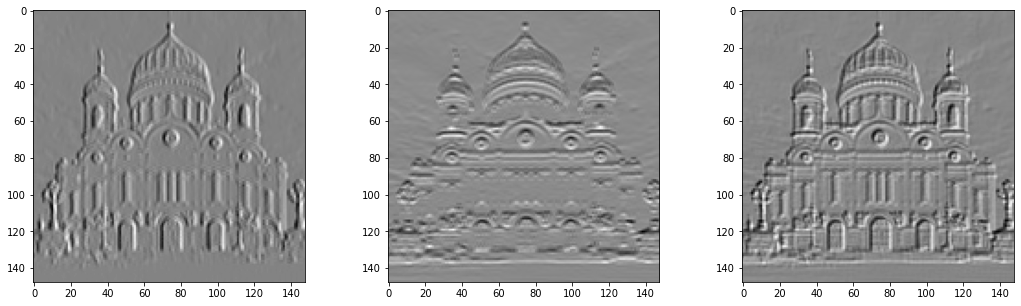

In [58]:
fig,(ax1,ax2,ax3) = plt.subplots( 1, 3, figsize=(18,5) )

# 원본 (나중에)

# 수직
ax1.imshow( vertical_conv_img, cmap='binary' )

# 수평
ax2.imshow( horizental_conv_img, cmap='binary' )

# 수직 + 수평 -> 외곽선 디텍팅
ax3.imshow( vertical_conv_img+horizental_conv_img, cmap='binary' )

plt.show()

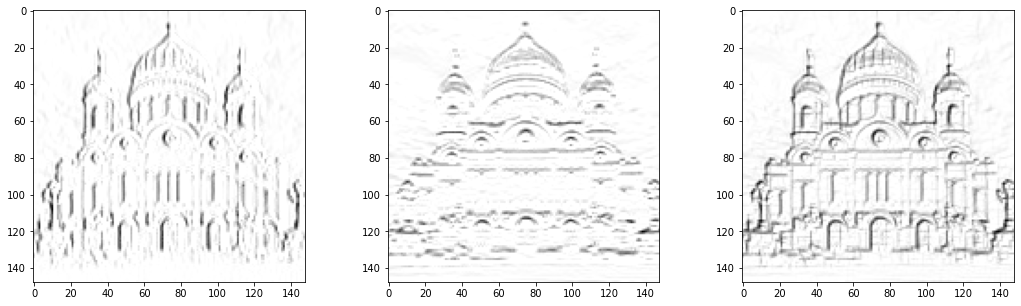

In [60]:
# 커널과 연산을 통해서 데이터에 잡음이 많이 생겼다 -> (음수값들)
# 음수값들을 일괄적으로 처리(0? 양수화? 기준이 있을듯) -> 다음층으로 보내겠다
# 활성화 함수의 업무중에 하나 -> relu를 사용하여 음수값을 일괄적으로 0으로 조정하겠다

fig,(ax1,ax2,ax3) = plt.subplots( 1, 3, figsize=(18,5) )

# 원본 (나중에)

# 수직
ax1.imshow( torch.relu( vertical_conv_img ), cmap='binary' )

# 수평
ax2.imshow( torch.relu(horizental_conv_img), cmap='binary' )

# 수직 + 수평 -> 외곽선 디텍팅
ax3.imshow( torch.relu( vertical_conv_img )+torch.relu(horizental_conv_img), cmap='binary' )

plt.show()

# 내가 만든 합성곱과 실제함수(API)와 결과 비교

In [61]:
import torch.nn as nn

In [63]:
# 이미지 원본 데이터로부터 정보를 생성
h, w = img_tensor.size()

In [65]:
# NHWC or NCHW( 토치에서 이미지 데이터 구성시 기본 순서 )
# 그레이스케일 > 1ch
curImg = img_tensor.view( 1, 1, h, w )
curImg.size()

torch.Size([1, 1, 150, 150])

In [70]:
batch, in_channel, _, _ = curImg.size()
# 기타 설정
out_channel = 1 # 1장을 합성곱에 넣어서 1장의 feature 맵이 나온다
kernel_size = 3 # 통상 커널은 h=w, 양으로 지정 (위에서 3크기로 커널을 생성했으므로 동일하게 구성)
stride = 1 # 위와 동일하게 구성

In [71]:
conv_layer = nn.Conv2d(
                          in_channels= in_channel,
                          out_channels= out_channel,
                          kernel_size= kernel_size,
                          stride = stride,
                          bias = False
                      )

In [72]:
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [74]:
# 가중치값 전달 (수정)
# api를 활용하면 내부적으로 가중치가 생성 -> 어차피 학습을 수행하면 조정되는 값
conv_layer.weight.data, conv_layer.weight.data.size()

(tensor([[[[-0.0634, -0.2427, -0.1531],
           [-0.2503, -0.0592,  0.0662],
           [-0.2620,  0.1566,  0.2897]]]]), torch.Size([1, 1, 3, 3]))

In [76]:
# kernel 2D -> 4D로 변경 -> 합성곱층의 가중치 데이터를 교체
conv_layer.weight.data = kernel.expand(1,1,kernel.size(0),kernel.size(1))

In [77]:
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [78]:
# 이미지를 합성곱층에 통과
convs = conv_layer( curImg)
convs.size()

torch.Size([1, 1, 148, 148])

In [79]:
# 행렬에 차원중에 1인 값을 모두 제거 함수 squeeze()
convs.squeeze().size()

torch.Size([148, 148])

In [81]:
# API를 통과시킨 이미지의 특징값과 내가 만든 합성곱을 통과시키니 이미지의 특징값이 동일한가?
# 행렬 == 행렬
# API의 기능과 내가 만든 기능이 동일
vertical_conv_img == convs.squeeze()

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

# 최대풀링 구현

# 내가 만든 최대풀링 vs 실제함수 (API)